In [2]:
import os

def enviorment_check(id):
    dir = './history/'
    if os.path.exists(dir) == False:
        os.makedirs(dir)
    save_folder = str(dir) + str(id) 
    os.makedirs(save_folder)
    return (save_folder + '/')

In [3]:
# define get data function

import pandas as pd
import numpy as np
import quandl

def GetStockData_PriceVolume(paras):
    '''
    All data is from quandl wiki dataset
    Feature set: [Open  High    Low  Close    Volume  Ex-Dividend  Split Ratio Adj. Open  Adj. High  Adj. Low  
    Adj. Close  Adj. Volume]
    '''
    
    # Prepare data frame
    stkname = "WIKI/" + str(paras.ticker)
    df = quandl.get(stkname, authtoken = '2c24stWyXfdzLVFWxGe4', start_date = paras.start_date, end_date = paras.end_date)
    df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
    df = df.rename(columns = {"Adj. Open": "open", "Adj. High": "high", "Adj. Low": "low",
                            "Adj. Close": "close", "Adj. Volume": "volume"})
    df_all = df.copy()
    df['MA'] = df['close'].rolling(window = paras.pred_len, center = False).mean()
    
    # Data frame output
    if paras.out_class_type == 'regression':
        if paras.out_type == 'MA':
            df['label'] = df['MA'].shift(-1 * paras.pred_len)
        else:
            df['label'] = df['close'].shift(-1 * paras.pred_len)
    else: # classification - FIXME
        df['label'] = df['close'].shift(-1 * paras.pred_len)
    
    # Generate input features for time series data
    featureset = list(['label'])
    featuresDict = {'c':'close', 'h':'high', 'l':'low', 'o':'open', 'v':'volume'}
    for i in range(paras.window_len, -1, -1):
        for j in list(paras.features):
            df[j+'_-'+str(i)+'_d'] = df[featuresDict[j]].shift(1*i)
            featureset.append(j+'_-'+str(i)+'_d')
    
    df = df[featureset]
    df_lately = df[-paras.pred_len:]
    df.dropna(inplace = True)
    df_known_lately = df[len(df) - paras.known_lately_len: len(df)]
    df = df[0:len(df)-paras.known_lately_len]

    if paras.debug_load_data == True:
        pd.set_option('display.max_columns', None)
        print (' %%%%%%%%%%%%%%% GetStockData PriceVolume Parameters Set %%%%%%%%%%%%%%% ')
        print (paras)
        print (' %%%%%%%%%%%%%%% GetStockData PriceVolume Feature Set %%%%%%%%%%%%%%% ')
        print (featureset)
        print (' %%%%%%%%%%%%%%% GetStockData PriceVolume df Statistic %%%%%%%%%%%%%%% ')
        print (df.describe())
        print (' %%%%%%%%%%%%%%% GetStockData PriceVolume df_known_lately Statistic %%%%%%%%%%%%%%% ')
        print (df_known_lately.describe())
        print (' %%%%%%%%%%%%%%% GetStockData PriceVolume df_lately Statistic %%%%%%%%%%%%%%% ')
        print (df_lately.describe())
    
    return df, df_known_lately, df_lately, df_all
    

In [4]:
# normalization/ preprocessing
from sklearn import preprocessing

def preprocessing_data_by_row(data, paras):
    '''
    data: N*M np.array
    N: sample
    M: features
    data_T: M*N
    data_T_scale: scaler for column by column, M*N
    data_T_scale_T: N*M
    '''
    if data.size == 0:
        return data, None
    
    data_T = data.transpose()
    if paras.preproc_scaler == 'standard_scaler':
        scaler = preprocessing.StandardScaler().fit(data_T)
    else: #FIXME
        scaler = preprocessing.StandardScaler().fit(data_T)
    data_T_scale = scaler.transform(data_T)
    data_T_scale_T = data_T_scale.transpose()
    return data_T_scale_T, scaler

In [5]:
def divide_into_price_volume(df, paras):
    '''
    df.columns = [..., o_-10_d,h_-10_d,l_-10_d,c_-10_d,v_-10_d,...]
    return [...,o_-10_d,h_-10_d,l_-10_d,c_-10_d,...], [...,v_-10_d,...]
    '''
    volume_cols = [col for col in df.columns if 'v_' in col]
    return np.array(df.drop(volume_cols, 1)), np.array(df[volume_cols])

In [6]:
def preprocessing_data(df, paras, featureDropForTraining, withLabel = True):
    '''
    df: pd.DataFrame
    X: np.array
    y: np.array
    convert df into X,y
    '''
    y = np.array(df['label'])
    X_price, X_volume = divide_into_price_volume(df.drop(featureDropForTraining, 1), paras)
    
    X_price, scaler_price = preprocessing_data_by_row(X_price, paras)
    X_volume, scaler_volume = preprocessing_data_by_row(X_volume, paras)
    
    # combine price and volume - rearrange
    # [...,o_-10_d,h_-10_d,l_-10_d,c_-10_d,...], [...,v_-10_d,...] -> [..., o_-10_d,h_-10_d,l_-10_d,c_-10_d,v_-10_d,...]
    X_combined = X_price
    if len(X_volume[0]) != 0:
        for i in range(len(X_volume[0])-1, -1, -1):
            X_combined = np.insert(X_combined, (i+1)*(paras.n_features-1), X_volume[:,i], axis = 1)

    if withLabel == True:
        y_normalized = scaler_price.transform(y.reshape(1,-1))    
        y_normalized_T = y_normalized.reshape(-1,1)
    else:
        y_normalized_T = np.repeat(float('nan'), len(y))
    scaler_combined = {'price': scaler_price, 'volume': scaler_volume}
    
    if paras.debug_preproc_data == True:
        print ('df[-1:]:',df[-1:])
        
        if scaler_price != None:
            print ('scaler_price len:', np.shape(scaler_price.mean_))
            print ('scaler_price mean:',scaler_price.mean_)
            print ('scaler_price var:',scaler_price.var_)
            print ('normalized price:',X_price[-1:])
            print ('inversed price:',scaler_price.inverse_transform(X_price.transpose())[:,-1])

        if scaler_volume != None:
            print ('scaler_volume len:', np.shape(scaler_volume.mean_))
            print ('scaler_volume mean:',scaler_volume.mean_)
            print ('scaler_volume var:',scaler_volume.var_)
            print ('normalized volume:',X_volume[-1:])
            print ('inversed volume:',scaler_volume.inverse_transform(X_volume.transpose())[:,-1])

        print ('X_price shape',X_price.shape)
        print ('X_volume shape',X_volume.shape)
        print ('X_combined shape',X_combined.shape)
        print ('X_combined',X_combined[-1:])
        
        print ('y[-1:]:', y[-1:])
        print ('y[-1] normalized:', y_normalized[-1:])
        print ('y[-1] inversed:', scaler_price.inverse_transform(y_normalized)[:,-1])
    
    return X_combined, y_normalized_T, scaler_combined

In [7]:
def reshape_input(X, y, paras):
    '''
    X.shape = [n_sample, window_len*n_features]
    X_reshaped = [n_sample, window_len, n_features]
    '''
    n_sample = X.shape[0]
    n_channel = paras.n_features
    n_features_per_channel = X.shape[1]/n_channel
    X_reshaped = np.reshape(X, (n_sample, n_features_per_channel, n_channel))
    y_reshaped = np.reshape(y, (n_sample,-1))
    return X_reshaped, y_reshaped

In [8]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

def build_LSTM_model(paras):
    model_lstm = Sequential()
    first = True
    for idx in range(len(paras.model['hidden_layers'])):
        if idx == (len(paras.model['hidden_layers']) - 1):
            model_lstm.add(LSTM(paras.model['hidden_layers'][idx], return_sequences = False))
            model_lstm.add(Activation(paras.model['activation'][idx]))
            model_lstm.add(Dropout(paras.model['dropout'][idx]))
        elif first == True:
            model_lstm.add(LSTM(input_dim = paras.n_features,
                                output_dim = paras.model['hidden_layers'][idx],
                                return_sequences = True))
            model_lstm.add(Activation(paras.model['activation'][idx]))
            model_lstm.add(Dropout(paras.model['dropout'][idx]))
            first = False
        else:
            model_lstm.add(LSTM(paras.model['hidden_layers'][idx], return_sequences = True))
            model_lstm.add(Activation(paras.model['activation'][idx]))
            model_lstm.add(Dropout(paras.model['dropout'][idx]))
   
    # output layer
    model_lstm.add(Dense(output_dim = paras.model['out_layer']))
    model_lstm.add(Activation(paras.model['out_activation']))
    model_lstm.compile(loss = paras.model['loss'], optimizer = paras.model['optimizer'])
    print ('build LSTM model...')
    return model_lstm

Using TensorFlow backend.


In [9]:
def LSTM_model_predict(model, X, y, scaler = None):
    predictions = model.predict(X)
    mse_scaled = np.mean((y - predictions) ** 2)
    print ('scaled data mse: ', mse_scaled)
    
    if scaler != None:
        arr = np.array(scaler.inverse_transform(y.reshape(y.shape[0],)))
        arr2 = np.array(scaler.inverse_transform(predictions.reshape(predictions.shape[0],)))
        return mse_scaled, arr, arr2
    return mse_scaled, None, None

In [10]:
def save_training_model(model, paras, name):
    # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
    model.save(paras.save_folder + name + '.h5')  # creates a HDF5 file 'my_model.h5'

In [11]:
from datetime import timedelta
def append_date_serires(df, paras):
    append_date = []
    append_last_date = df.index[-1]
    i = paras.pred_len
    while i >= 1:
        append_last_date = append_last_date + timedelta(days=1)
        if append_last_date.isoweekday() > 0 and append_last_date.isoweekday() < 6:
            append_date.append(append_last_date)
            i -= 1
    append_df = pd.DataFrame(index = list(append_date))
    df = pd.concat((df, append_df), axis=0)
    return df

In [12]:
def save_data_frame_mse(df, paras, mses):
    if 1:
        df['actual'] = df['actual']
        df['pred'] = df['pred']
        df = df.rename(columns = {"actual": "a_+"+str(paras.pred_len)+'_d',
                                  "pred": "p_+"+str(paras.pred_len)+'_d'})
        
        df['a_+'+str(paras.pred_len)+'_d_diff'] = df["a_+"+str(paras.pred_len)+'_d'] - df['close']
        df['p_+'+str(paras.pred_len)+'_d_diff'] = df["p_+"+str(paras.pred_len)+'_d'] - df['close']
        new_list = ["a_+"+str(paras.pred_len)+'_d', "p_+"+str(paras.pred_len)+'_d', 
                    'a_+'+str(paras.pred_len)+'_d_diff', 'p_+'+str(paras.pred_len)+'_d_diff']
    else :
        df = append_date_serires(df, paras)
        # shift +
        df['actual'] = df['actual'].shift(paras.pred_len)
        df['pred'] = df['pred'].shift(paras.pred_len)
        df = df.rename(columns = {"actual": "a_-"+str(paras.pred_len)+'_d',
                                  "pred": "p_-"+str(paras.pred_len)+'_d'})
        new_list = ["a_-"+str(paras.pred_len)+'_d', "p_-"+str(paras.pred_len)+'_d']
    
    default_list = ['open', 'high', 'low', 'close', 'volume']
    original_other_list = set(df.columns) - set(default_list) - set(new_list)
    original_other_list = list(original_other_list)
    df = df[default_list + original_other_list + new_list]
    model_acc = mses[1] / mses[0]
    df.to_csv(paras.save_folder + paras.ticker + ('_%.2f' % model_acc)+ "_data_frame.csv")
    with open(paras.save_folder + 'parameters.txt', "w") as text_file:
        text_file.write(paras.__str__())
        text_file.write(str(mses[0]) + '\n')
        text_file.write(str(mses[1]) + '\n')
    return df

In [13]:
# plot
# http://matplotlib.org/examples/pylab_examples/subplots_demo.html

import matplotlib.pyplot as plt
import csv
    
def plot_training_curve(history, paras, save = True):
    # LSTM model plot
    # from keras.utils.visualize_util import plot
    # from IPython.display import SVG
    # from keras.utils.visualize_util import model_to_dot
    # plot(model_lstm, to_file='model.png')
    # SVG(model_to_dot(model_lstm).create(prog='dot', format='svg'))
    
    %matplotlib inline
    # Control the default size of figures in this Jupyter notebook
    %pylab inline
    pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

    # LSTM training 
    f, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('loss function')
    ax.set_ylabel('mse')
    ax.set_xlabel('epoch')
    ax.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()
    if save == True:
        w = csv.writer(open(paras.save_folder + "training_curve_model.txt", "w"))
        for key, val in history.history.items():
            w.writerow([key, val])
        for key, val in history.params.items():
            w.writerow([key, val])   
    

In [14]:
from sklearn import cross_validation
from keras.callbacks import History 

def run_LSTM(paras):
    ################################################################################
    paras.save_folder = enviorment_check(paras.identify)
    print ('save directory: ', paras.save_folder)
    ################################################################################

    featureDropForTraining = ['label']

    # get data
    df, df_known_lately, df_lately, df_all = GetStockData_PriceVolume(paras)

    # preprocessing
    X, y, scaler = preprocessing_data(df, paras, featureDropForTraining, withLabel = True)
    X_known_lately, y_known_lately, scaler_known_lately = preprocessing_data(df_known_lately, paras, featureDropForTraining, withLabel = True)
    X_lately, y_lately, scaler_lately = preprocessing_data(df_lately, paras, featureDropForTraining, withLabel = False)

    # cross validation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
    print ('train shape',X_train.shape)
    print ('test shape',X_test.shape)

    # reshape input data to LSTM model
    X_train, y_train = reshape_input(X_train, y_train, paras)
    X_test, y_test = reshape_input(X_test, y_test, paras)
    X_known_lately, y_known_lately = reshape_input(X_known_lately, y_known_lately, paras)
    X_lately, y_lately = reshape_input(X_lately, y_lately, paras)

    # build LSTM model
    history = History()
    model_lstm = build_LSTM_model(paras)
    model_lstm.fit(
        X_train,
        y_train,
        batch_size = paras.batch_size,
        nb_epoch = paras.epoch,
        validation_split = paras.validation_split,
        #validation_data = (X_known_lately, y_known_lately),
        callbacks=[history],
        verbose = 1
    )
    # save model
    save_training_model(model_lstm, paras, 'lstm_model')

    # validation test + known lately data 
    print (' ############## validation on test data ############## ')
    mse_test, tmp, tmp2 = LSTM_model_predict(model_lstm, X_test, y_test)

    print (' ############## validation on known lately data ############## ')
    mse_known_lately, df_all.loc[df_known_lately.index, 'actual'], df_all.loc[df_known_lately.index, 'pred'] = LSTM_model_predict(model_lstm, X_known_lately, y_known_lately, 
                                                      scaler = scaler_known_lately['price'])
    # predict lately data
    print (' ############## validation on lately data ############## ')
    mse_lately, df_all.loc[df_lately.index, 'actual'], df_all.loc[df_lately.index, 'pred'] = LSTM_model_predict(model_lstm, X_lately, y_lately, 
                                       scaler = scaler_lately['price'])

    # rewrite data frame and save / update
    df_all = save_data_frame_mse(df_all, paras, mses = [mse_test, mse_known_lately])

    # plot training loss/ validation loss
    plot_training_curve(history, paras, save = True)

    print (df_all[-(paras.pred_len+paras.known_lately_len):])

save directory:  ./history/LSTM_NDAQ_2017-03-03 20:06:34/
train shape (1203, 1305)
test shape (301, 1305)


/Users/christsai/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


build LSTM model...
Train on 1082 samples, validate on 121 samples
Epoch 1/100
1082/1082 [==============================] - 47s - loss: 1.1056 - val_loss: 0.4868
Epoch 2/100
1082/1082 [==============================] - 46s - loss: 0.6411 - val_loss: 0.4440
Epoch 3/100
1082/1082 [==============================] - 47s - loss: 0.5609 - val_loss: 0.3105
Epoch 4/100
1082/1082 [==============================] - 48s - loss: 0.5128 - val_loss: 0.2819
Epoch 5/100
1082/1082 [==============================] - 48s - loss: 0.4880 - val_loss: 0.2764
Epoch 6/100
1082/1082 [==============================] - 48s - loss: 0.4116 - val_loss: 0.3192
Epoch 7/100
1082/1082 [==============================] - 48s - loss: 0.4094 - val_loss: 0.3558
Epoch 8/100
1082/1082 [==============================] - 48s - loss: 0.4240 - val_loss: 0.1997
Epoch 9/100
1082/1082 [==============================] - 48s - loss: 0.3797 - val_loss: 0.1945
Epoch 10/100
1082/1082 [==============================] - 48s - loss: 0.3327 -

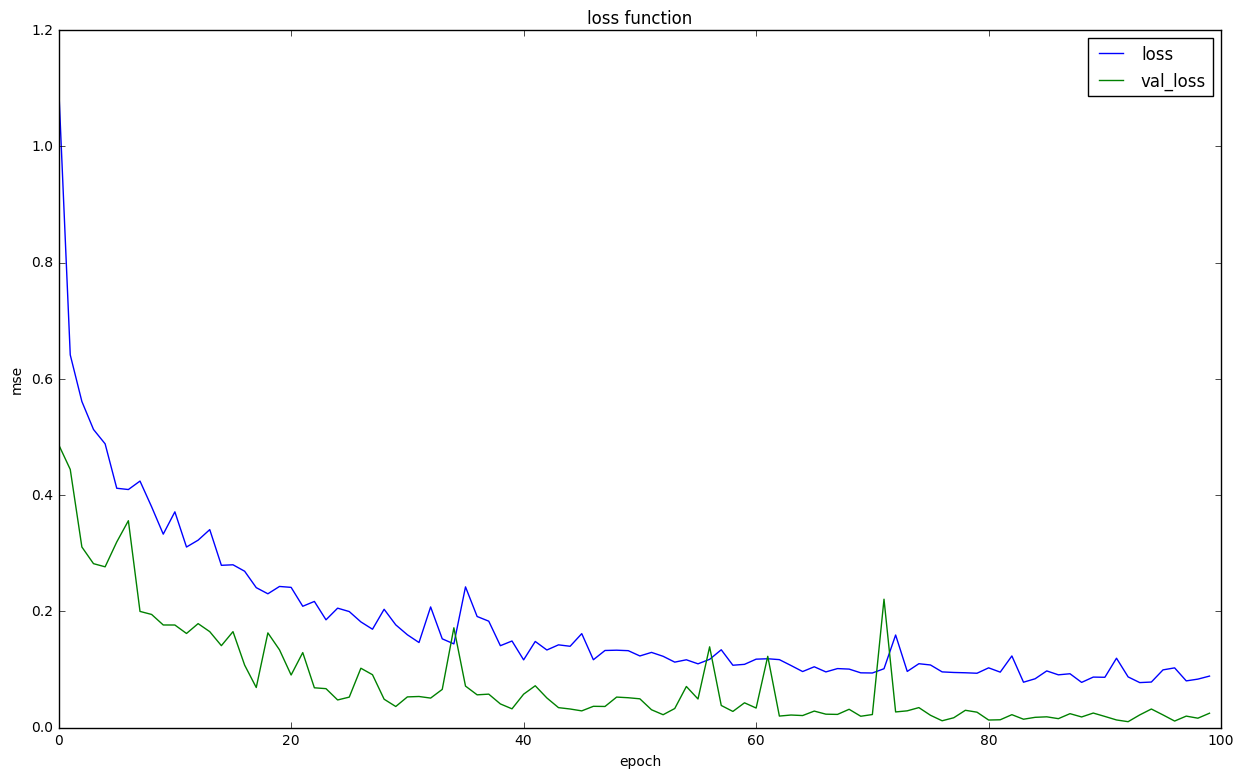

             open    high      low  close     volume  a_+20_d    p_+20_d  \
Date                                                                       
2017-01-05  67.49  68.150  67.2400  67.64   620788.0  68.3100  67.882111   
2017-01-06  67.62  68.810  67.5200  68.46   613449.0  68.3740  67.940720   
2017-01-09  68.37  68.450  67.3300  67.77   639088.0  68.4535  67.995758   
2017-01-10  67.62  67.870  67.1700  67.20   832992.0  68.5375  68.035210   
2017-01-11  67.19  67.800  66.8900  67.72   482040.0  68.6065  68.069275   
2017-01-12  67.44  67.550  66.1000  67.40   500342.0  68.7250  68.086884   
2017-01-13  67.33  67.920  67.2400  67.71   431935.0  68.8745  68.092026   
2017-01-17  67.36  67.680  66.8900  66.99   908438.0  69.0640  68.077423   
2017-01-18  66.71  67.290  66.6200  67.25   775115.0  69.2640  68.051910   
2017-01-19  67.06  67.340  66.4900  67.06   624994.0  69.4780  68.023567   
2017-01-20  67.30  67.580  66.8400  67.36   602269.0  69.6855  67.992577   
2017-01-23  

In [18]:
import US_SP_Global_Parameters
if __name__ == "__main__":
    # #################### parameters setting ####################
    paras = US_SP_Global_Parameters.SP_RNN_LSTM_Paras('LSTM', ticker = 'NDAQ')
    paras.features = 'ohlcv'
    paras.window_len = 260
    paras.pred_len = 20
    paras.known_lately_len = 20
    paras.debug_load_data = False
    paras.debug_preproc_data = False

    # LSTM parameters
    paras.batch_size = 128
    paras.epoch = 100
    paras.validation_split = 0.1
    paras.model['hidden_layers'] = [120, 60, 30]
    paras.model['dropout'] = [0.7, 0.5, 0.3]
    paras.model['activation'] = ['relu', 'relu', 'relu']
    paras.model['out_layer'] = 1
    paras.model['out_activation'] = 'linear'
    paras.model['loss'] = 'mse'
    paras.model['optimizer'] = 'rmsprop'

    run_LSTM(paras)

save directory:  ./history/LSTM_AAPL_2017-03-03 21:22:07/
train shape (1203, 1305)
test shape (301, 1305)


/Users/christsai/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


build LSTM model...
Train on 1082 samples, validate on 121 samples
Epoch 1/100
1082/1082 [==============================] - 37s - loss: 1.8004 - val_loss: 0.8148
Epoch 2/100
1082/1082 [==============================] - 34s - loss: 0.8314 - val_loss: 0.5815
Epoch 3/100
1082/1082 [==============================] - 35s - loss: 0.7065 - val_loss: 0.5156
Epoch 4/100
1082/1082 [==============================] - 35s - loss: 0.6201 - val_loss: 0.4354
Epoch 5/100
1082/1082 [==============================] - 35s - loss: 0.5290 - val_loss: 0.4846
Epoch 6/100
1082/1082 [==============================] - 35s - loss: 0.4919 - val_loss: 0.3618
Epoch 7/100
1082/1082 [==============================] - 35s - loss: 0.4711 - val_loss: 0.3303
Epoch 8/100
1082/1082 [==============================] - 35s - loss: 0.4533 - val_loss: 0.3077
Epoch 9/100
1082/1082 [==============================] - 35s - loss: 0.3998 - val_loss: 0.2907
Epoch 10/100
1082/1082 [==============================] - 35s - loss: 0.3644 -

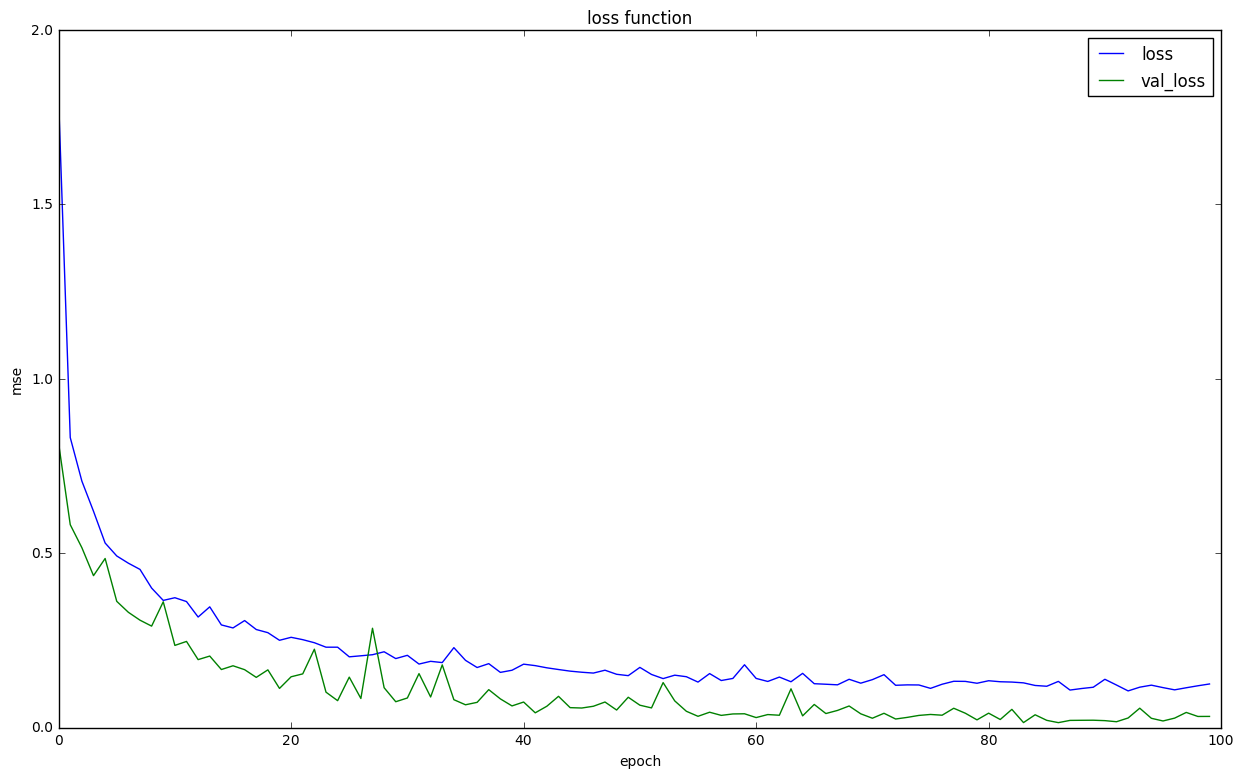

                  open        high         low       close       volume  \
Date                                                                      
2017-01-05  115.421739  116.361880  115.312212  116.128687   21930515.0   
2017-01-06  116.278042  117.652111  115.969375  117.403185   31077492.0   
2017-01-09  117.443013  118.916652  117.433056  118.468586   33293974.0   
2017-01-10  118.259489  118.866867  117.791509  118.598027   24154214.0   
2017-01-11  118.229618  119.414503  118.090219  119.235276   27298488.0   
2017-01-12  118.383951  118.787211  117.701896  118.737426   26832752.0   
2017-01-13  118.598027  119.105835  118.299317  118.508414   25529003.0   
2017-01-17  117.831337  119.723170  117.711853  119.459309   33770809.0   
2017-01-18  119.484202  119.982053  119.195448  119.474245   23306832.0   
2017-01-19  118.886781  119.573815  118.856910  119.265147   25160249.0   
2017-01-20  119.932268  119.932268  119.219943  119.484202   28866416.0   
2017-01-23  119.484202  1

In [19]:
import US_SP_Global_Parameters
if __name__ == "__main__":
    # #################### parameters setting ####################
    paras = US_SP_Global_Parameters.SP_RNN_LSTM_Paras('LSTM', ticker = 'AAPL')
    paras.features = 'ohlcv'
    paras.window_len = 260
    paras.pred_len = 20
    paras.known_lately_len = 20
    paras.debug_load_data = False
    paras.debug_preproc_data = False

    # LSTM parameters
    paras.batch_size = 128
    paras.epoch = 100
    paras.validation_split = 0.1
    paras.model['hidden_layers'] = [120, 60, 30]
    paras.model['dropout'] = [0.7, 0.5, 0.3]
    paras.model['activation'] = ['relu', 'relu', 'relu']
    paras.model['out_layer'] = 1
    paras.model['out_activation'] = 'linear'
    paras.model['loss'] = 'mse'
    paras.model['optimizer'] = 'rmsprop'

    run_LSTM(paras)

save directory:  ./history/LSTM_GOOGL_2017-03-03 22:21:01/
train shape (1203, 1305)
test shape (301, 1305)


/Users/christsai/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


build LSTM model...
Train on 1082 samples, validate on 121 samples
Epoch 1/100
1082/1082 [==============================] - 37s - loss: 1.9340 - val_loss: 1.3363
Epoch 2/100
1082/1082 [==============================] - 34s - loss: 1.0319 - val_loss: 0.9576
Epoch 3/100
1082/1082 [==============================] - 34s - loss: 0.7682 - val_loss: 0.7140
Epoch 4/100
1082/1082 [==============================] - 35s - loss: 0.6293 - val_loss: 0.6100
Epoch 5/100
1082/1082 [==============================] - 35s - loss: 0.5723 - val_loss: 0.5352
Epoch 6/100
1082/1082 [==============================] - 35s - loss: 0.5629 - val_loss: 0.4925
Epoch 7/100
1082/1082 [==============================] - 34s - loss: 0.4963 - val_loss: 0.4428
Epoch 8/100
1082/1082 [==============================] - 34s - loss: 0.4744 - val_loss: 0.4635
Epoch 9/100
1082/1082 [==============================] - 34s - loss: 0.4636 - val_loss: 0.4259
Epoch 10/100
1082/1082 [==============================] - 34s - loss: 0.4040 -

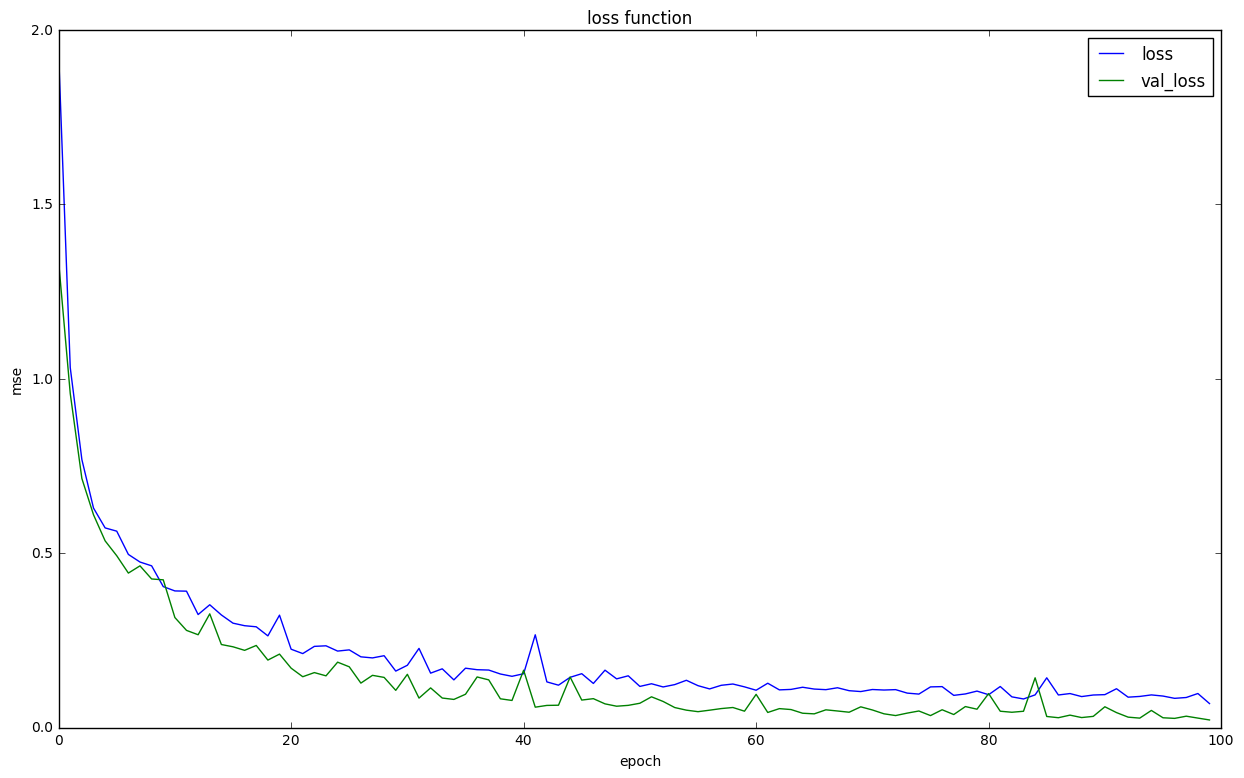

              open      high       low   close     volume   a_+20_d  \
Date                                                                  
2017-01-05  807.50  813.7400  805.9200  813.02  1318301.0  831.4780   
2017-01-06  814.99  828.9600  811.5000  825.21  1983025.0  831.2985   
2017-01-09  826.37  830.4300  821.6200  827.18  1405091.0  831.4010   
2017-01-10  827.07  829.4100  823.1400  826.01  1141799.0  831.5945   
2017-01-11  826.62  829.9000  821.4700  829.86  1261666.0  831.6045   
2017-01-12  828.38  830.3800  821.0100  829.53  1348274.0  831.8705   
2017-01-13  831.00  834.6500  829.5200  830.94  1255255.0  832.2715   
2017-01-17  830.00  830.1800  823.2001  827.20  1242810.0  832.9130   
2017-01-18  829.80  829.8100  824.0800  829.02   989477.0  833.3280   
2017-01-19  829.00  832.9999  823.9600  824.37  1065121.0  834.2180   
2017-01-20  829.09  829.2400  824.6000  828.17  1259321.0  835.1370   
2017-01-23  831.61  845.5428  828.7000  844.43  2445107.0  835.3790   
2017-0

In [20]:
import US_SP_Global_Parameters
if __name__ == "__main__":
    # #################### parameters setting ####################
    paras = US_SP_Global_Parameters.SP_RNN_LSTM_Paras('LSTM', ticker = 'GOOGL')
    paras.features = 'ohlcv'
    paras.window_len = 260
    paras.pred_len = 20
    paras.known_lately_len = 20
    paras.debug_load_data = False
    paras.debug_preproc_data = False

    # LSTM parameters
    paras.batch_size = 128
    paras.epoch = 100
    paras.validation_split = 0.1
    paras.model['hidden_layers'] = [120, 60, 30]
    paras.model['dropout'] = [0.7, 0.5, 0.3]
    paras.model['activation'] = ['relu', 'relu', 'relu']
    paras.model['out_layer'] = 1
    paras.model['out_activation'] = 'linear'
    paras.model['loss'] = 'mse'
    paras.model['optimizer'] = 'rmsprop'

    run_LSTM(paras)